In [1]:
import pathlib
import os
import sys
import subprocess
import logging
import platform

from dataclasses import dataclass

import cv2 as cv
# import matplotlib.pyplot as plt

def fatal_error(msg):
  logging.critical(msg)
  breakpoint()
  sys.exit()

def warn(msg):
  logging.warning(msg)
  # NOTE(Ryan): Disable by passing -O to interpreter
  if __debug__:
    breakpoint()
    sys.exit()

def trace(msg):
  if __debug__:
    logging.debug(msg)


# what is format of input image?
# 1. Open and read image files.
# 2. Display and write image files. (binary segmented image)
# 3. Perform basic image processing operations on images.
# 4. Implement and apply various automatic thresholding techniques to images.

# For this assignment (same as for the labs), make sure that in your Jupyter notebook the
# input images are readable from the location specified as an argument, and all output images
# and other requested results are displayed in the notebook environment. All cells in your
# notebook should have been executed so that the tutor/marker does not have to execute the
# notebook again to see the results.
def make_empty_matrix(n):
  return [[0] * n for i in range(n)]


def clamp(val, limit):
  clamped_val = val

  if val < 0:
    clamped_val = 0
  elif val >= limit:
    clamped_val = limit - 1
  
  return clamped_val

def translate(x0, x1, val, x2, x3):
  val_fraction = ((val - x0) / (x1 - x0))
  
  return x2 + (val_fraction * (x3 - x2))

def make_k3x3_laplace():
  k3x3 = make_empty_matrix(3)

  k3x3[0][0] = 0 
  k3x3[1][0] = 1 
  k3x3[2][0] = 0 

  k3x3[0][1] = 1 
  k3x3[1][1] = -4 
  k3x3[2][1] = 1 

  k3x3[0][2] = 0 
  k3x3[1][2] = 1 
  k3x3[2][2] = 0 

  return k3x3

def convolve_k3x3_laplace(k3x3, m3x3):
  result = 0

  for x in range(3):
    for y in range(3):
      result += (k3x3[y][x] * m3x3[y][x])

  return result

def make_m3x3_from_cv_image(cv_img, centre_x, centre_y):
  m3x3 = make_empty_matrix(3)

  w = cv_img.shape[1]
  h = cv_img.shape[0]

  # NOTE(Ryan): Duplicating last pixel for border problem   
  x00 = clamp(centre_x - 1, w)
  x01 = clamp(centre_x, w)
  x02 = clamp(centre_x + 1, w)

  y00 = clamp(centre_y - 1, h)
  y01 = clamp(centre_y, h)
  y02 = clamp(centre_y + 1, h)

  # NOTE(Ryan): First pixel is fine as greyscale
  m3x3[0][0] = cv_img[y00, x00][0] 
  m3x3[0][1] = cv_img[y00, x01][0]
  m3x3[0][2] = cv_img[y00, x02][0]

  m3x3[1][0] = cv_img[y01, x00][0]
  m3x3[1][1] = cv_img[y01, x01][0]
  m3x3[1][2] = cv_img[y01, x02][0]

  m3x3[2][0] = cv_img[y02, x00][0] 
  m3x3[2][1] = cv_img[y02, x01][0]
  m3x3[2][2] = cv_img[y02, x02][0]

  return m3x3


def compute_laplacian(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  k3x3_laplace = make_k3x3_laplace() 

  output_img_gray_values = [0] * (img_width * img_height)
  
  for x in range(img_width):
    for y in range(img_height):
      m3x3 = make_m3x3_from_cv_image(img, x, y)

      gray_value = convolve_k3x3_laplace(k3x3_laplace, m3x3)

      output_img_gray_values[y * img_width + x] = gray_value

  min_convolved = min(output_img_gray_values)
  max_convolved = max(output_img_gray_values)

  for x in range(img_width):
    for y in range(img_height):
      cur_gray = output_img_gray_values[y * img_width + x]
      normalised_gray = translate(min_convolved, max_convolved, cur_gray, 0, 255)
      output_img[y, x] = [normalised_gray] * 3
 
  return output_img

def contrast_stretch(i, a, b, c, d):
  return (i - c) * ((b - a) / (d - c)) + a

# TODO(Ryan): For BGR, generalise for number of channels
def contrast_stretch_grayscale(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  min_input = sys.maxsize
  max_input = 0
  for x in range(img_width):
    for y in range(img_height):
      gray_value = img[y, x][0]
      if gray_value > max_input:
        max_input = gray_value
      if gray_value < min_input:
        min_input = gray_value

  for x in range(img_width):
    for y in range(img_height):
      output_img[y, x] = [contrast_stretch(img[y, x][0], 0, 255, min_input, max_input)] * 3

  return output_img


def main():
  trace(f"opencv: {cv.__version__}")

  images_dir="COMP9517_23T2_Lab1_Images"

  einstein_img = cv.imread(f"{images_dir}/Einstein.png")
  laplacian_img = compute_laplacian(einstein_img)

  contrast_stretched_laplacian_img = contrast_stretch_grayscale(laplacian_img)

  # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # cv2 uses BGR but plt uses RGB, hence the conversion
  cv.imshow('contrast_stretched_laplacian_img', contrast_stretched_laplacian_img)
  cv.waitKey()


if __name__ == "__main__":
  # NOTE(Ryan): Disable breakpoints if not running under a debugger
  # if sys.gettrace() is None:
  #   os.environ["PYTHONBREAKPOINT"] = "0"

  # directory_of_running_script = pathlib.Path(__file__).parent.resolve()
  # os.chdir(directory_of_running_script)

  logging.basicConfig(level=logging.DEBUG)

  trace(f"python: {platform.python_version()}")

  main()


DEBUG:root:python: 3.8.10
DEBUG:root:opencv: 4.2.0


DEBUG:matplotlib:$HOME=/home/ryan
DEBUG:matplotlib:CONFIGDIR=/home/ryan/.config/matplotlib
DEBUG:matplotlib:matplotlib data path: /usr/share/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /etc/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.1.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', '_distutils_hack', 'apport_python_hook', 'sitecustomize', 'site', 'importlib._bootstrap', 'importlib._bootstrap_external', 'types', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'ope

DEBUG:matplotlib:CACHEDIR=/home/ryan/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/ryan/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:root:python: 3.8.10
DEBUG:root:opencv: 4.2.0
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Pagul' (Pagul.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal bold condensed>) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Symbols' (NotoSansSymbols-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Purisa' (Purisa-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Ahom' (NotoSerifAhom-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'URW Bookman' (URWBookman-Demi.otf) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mahajani' (NotoSansMahajani

DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Bonum' (texgyrebonum-bolditalic.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Heros Cn' (texgyreheroscn-bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Devanagari' (NotoSansDevanagari-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-HairlineItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Hatran' (NotoSansHatran-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Limbu' (NotoSansLimbu-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif CJK JP' (NotoSerifCJK-Bold.ttc) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '

DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Heros' (texgyreheros-bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Sans Demi Cond' (lmsansdemicond10-oblique.otf) oblique normal demi condensed>) = 11.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Dyuthi' (Dyuthi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Mono Caps' (lmmonocaps10-oblique.otf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gurmukhi' (NotoSansGurmukhi-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif' (NotoSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Display

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Jamrul' (JamrulNormal.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rasa' (Rasa-SemiBold.ttf) normal normal semibold normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Termes' (texgyretermes-italic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Padauk' (Padauk-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstOne' (KacstOne-Bold.ttf) normal normal bo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSerif' (FreeSerifBold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Kannada' (NotoSerifKannada-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliqUrdu-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chandas' 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Manichaean' (NotoSansManichaean-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSerif' (FreeSerifBoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typist' (TlwgTypist-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gurmukhi UI' (NotoSansGurmukhiUI-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukti Narrow' (MuktiNarrowBold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Heros Cn' (texgyr

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Bengali UI' (NotoSansBengaliUI-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Batak' (NotoSansBatak-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Hungarian' (NotoSansOldHungarian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Schola' (texgyreschola-italic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSans' (FreeSansBold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'La

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Light.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Sans' (lmsans17-regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Psalter Pahlavi' (NotoSansPsalterPahlavi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Mono' (NotoMono-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rasa' (Rasa-Light.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Pagella Math' (texgyrepagella-math.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Adventor' (texgyreadventor-bolditalic.o

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Sans' (lmsans10-bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'URW Bookman' (URWBookman-Light.otf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Likhan' (LikhanNormal.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Saab' (Saab.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Pagella' (texgyrepagella-regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans' (NotoSans-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Termes' (texgyretermes-bolditalic.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cham' (NotoSansCham-Regular.ttf) normal normal regular normal>) 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-LI.ttf) italic normal light normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'URW Gothic' (URWGothic-DemiOblique.otf) oblique normal demi normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'eufm10' (eufm10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-MI.ttf) italic normal medium normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'N

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-LightOblique.ttf) oblique normal light normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukti Narrow' (MuktiNarrow.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Telugu' (Lohit-Telugu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstNaskh' (KacstNaskh.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Sans Quotation' (lmsansquot8-boldoblique.otf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-Bold.ttf)

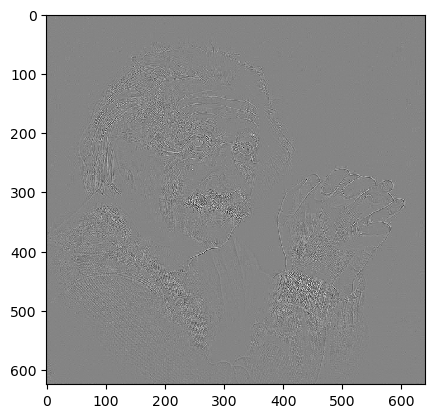

In [2]:
import pathlib
import os
import sys
import subprocess
import logging
import platform

from dataclasses import dataclass

import cv2 as cv
import matplotlib.pyplot as plt

def fatal_error(msg):
  logging.critical(msg)
  breakpoint()
  sys.exit()

def warn(msg):
  logging.warning(msg)
  # NOTE(Ryan): Disable by passing -O to interpreter
  if __debug__:
    breakpoint()
    sys.exit()

def trace(msg):
  if __debug__:
    logging.debug(msg)


# what is format of input image?
# 1. Open and read image files.
# 2. Display and write image files. (binary segmented image)
# 3. Perform basic image processing operations on images.
# 4. Implement and apply various automatic thresholding techniques to images.

# For this assignment (same as for the labs), make sure that in your Jupyter notebook the
# input images are readable from the location specified as an argument, and all output images
# and other requested results are displayed in the notebook environment. All cells in your
# notebook should have been executed so that the tutor/marker does not have to execute the
# notebook again to see the results.
def make_empty_matrix(n):
  return [[0] * n for i in range(n)]


def clamp(val, limit):
  clamped_val = val

  if val < 0:
    clamped_val = 0
  elif val >= limit:
    clamped_val = limit - 1
  
  return clamped_val

def translate(x0, x1, val, x2, x3):
  val_fraction = ((val - x0) / (x1 - x0))
  
  return x2 + (val_fraction * (x3 - x2))

def make_k3x3_laplace():
  k3x3 = make_empty_matrix(3)

  k3x3[0][0] = 0 
  k3x3[1][0] = 1 
  k3x3[2][0] = 0 

  k3x3[0][1] = 1 
  k3x3[1][1] = -4 
  k3x3[2][1] = 1 

  k3x3[0][2] = 0 
  k3x3[1][2] = 1 
  k3x3[2][2] = 0 

  return k3x3

def convolve_k3x3_laplace(k3x3, m3x3):
  result = 0

  for x in range(3):
    for y in range(3):
      result += (k3x3[y][x] * m3x3[y][x])

  return result

def make_m3x3_from_cv_image(cv_img, centre_x, centre_y):
  m3x3 = make_empty_matrix(3)

  w = cv_img.shape[1]
  h = cv_img.shape[0]

  # NOTE(Ryan): Duplicating last pixel for border problem   
  x00 = clamp(centre_x - 1, w)
  x01 = clamp(centre_x, w)
  x02 = clamp(centre_x + 1, w)

  y00 = clamp(centre_y - 1, h)
  y01 = clamp(centre_y, h)
  y02 = clamp(centre_y + 1, h)

  # NOTE(Ryan): First pixel is fine as greyscale
  m3x3[0][0] = cv_img[y00, x00][0] 
  m3x3[0][1] = cv_img[y00, x01][0]
  m3x3[0][2] = cv_img[y00, x02][0]

  m3x3[1][0] = cv_img[y01, x00][0]
  m3x3[1][1] = cv_img[y01, x01][0]
  m3x3[1][2] = cv_img[y01, x02][0]

  m3x3[2][0] = cv_img[y02, x00][0] 
  m3x3[2][1] = cv_img[y02, x01][0]
  m3x3[2][2] = cv_img[y02, x02][0]

  return m3x3


def compute_laplacian(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  k3x3_laplace = make_k3x3_laplace() 

  output_img_gray_values = [0] * (img_width * img_height)
  
  for x in range(img_width):
    for y in range(img_height):
      m3x3 = make_m3x3_from_cv_image(img, x, y)

      gray_value = convolve_k3x3_laplace(k3x3_laplace, m3x3)

      output_img_gray_values[y * img_width + x] = gray_value

  min_convolved = min(output_img_gray_values)
  max_convolved = max(output_img_gray_values)

  for x in range(img_width):
    for y in range(img_height):
      cur_gray = output_img_gray_values[y * img_width + x]
      normalised_gray = translate(min_convolved, max_convolved, cur_gray, 0, 255)
      output_img[y, x] = [normalised_gray] * 3
 
  return output_img

def contrast_stretch(i, a, b, c, d):
  return (i - c) * ((b - a) / (d - c)) + a

# TODO(Ryan): For BGR, generalise for number of channels
def contrast_stretch_grayscale(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  min_input = sys.maxsize
  max_input = 0
  for x in range(img_width):
    for y in range(img_height):
      gray_value = img[y, x][0]
      if gray_value > max_input:
        max_input = gray_value
      if gray_value < min_input:
        min_input = gray_value

  for x in range(img_width):
    for y in range(img_height):
      output_img[y, x] = [contrast_stretch(img[y, x][0], 0, 255, min_input, max_input)] * 3

  return output_img


def main():
  trace(f"opencv: {cv.__version__}")

  images_dir="COMP9517_23T2_Lab1_Images"

  einstein_img = cv.imread(f"{images_dir}/Einstein.png")
  laplacian_img = compute_laplacian(einstein_img)

  contrast_stretched_laplacian_img = contrast_stretch_grayscale(laplacian_img)

  #plt.imshow(cv.cvtColor(image, cv2.COLOR_BGR2RGB)) # cv2 uses BGR but plt uses RGB, hence the conversion
  plt.imshow(contrast_stretched_laplacian_img)
  # cv.imshow('contrast_stretched_laplacian_img', contrast_stretched_laplacian_img)
  # cv.waitKey()


if __name__ == "__main__":
  # NOTE(Ryan): Disable breakpoints if not running under a debugger
  # if sys.gettrace() is None:
  #   os.environ["PYTHONBREAKPOINT"] = "0"

  # directory_of_running_script = pathlib.Path(__file__).parent.resolve()
  # os.chdir(directory_of_running_script)

  logging.basicConfig(level=logging.DEBUG)

  trace(f"python: {platform.python_version()}")

  main()


DEBUG:root:python: 3.8.10
DEBUG:root:opencv: 4.2.0


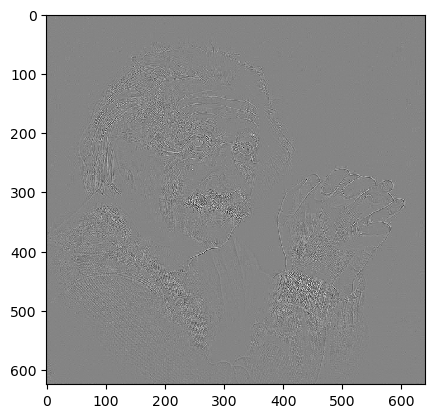

In [3]:
import pathlib
import os
import sys
import subprocess
import logging
import platform

from dataclasses import dataclass

import cv2 as cv
import matplotlib.pyplot as plt

def fatal_error(msg):
  logging.critical(msg)
  breakpoint()
  sys.exit()

def warn(msg):
  logging.warning(msg)
  # NOTE(Ryan): Disable by passing -O to interpreter
  if __debug__:
    breakpoint()
    sys.exit()

def trace(msg):
  if __debug__:
    logging.debug(msg)


# what is format of input image?
# 1. Open and read image files.
# 2. Display and write image files. (binary segmented image)
# 3. Perform basic image processing operations on images.
# 4. Implement and apply various automatic thresholding techniques to images.

# For this assignment (same as for the labs), make sure that in your Jupyter notebook the
# input images are readable from the location specified as an argument, and all output images
# and other requested results are displayed in the notebook environment. All cells in your
# notebook should have been executed so that the tutor/marker does not have to execute the
# notebook again to see the results.
def make_empty_matrix(n):
  return [[0] * n for i in range(n)]


def clamp(val, limit):
  clamped_val = val

  if val < 0:
    clamped_val = 0
  elif val >= limit:
    clamped_val = limit - 1
  
  return clamped_val

def translate(x0, x1, val, x2, x3):
  val_fraction = ((val - x0) / (x1 - x0))
  
  return x2 + (val_fraction * (x3 - x2))

def make_k3x3_laplace():
  k3x3 = make_empty_matrix(3)

  k3x3[0][0] = 0 
  k3x3[1][0] = 1 
  k3x3[2][0] = 0 

  k3x3[0][1] = 1 
  k3x3[1][1] = -4 
  k3x3[2][1] = 1 

  k3x3[0][2] = 0 
  k3x3[1][2] = 1 
  k3x3[2][2] = 0 

  return k3x3

def convolve_k3x3_laplace(k3x3, m3x3):
  result = 0

  for x in range(3):
    for y in range(3):
      result += (k3x3[y][x] * m3x3[y][x])

  return result

def make_m3x3_from_cv_image(cv_img, centre_x, centre_y):
  m3x3 = make_empty_matrix(3)

  w = cv_img.shape[1]
  h = cv_img.shape[0]

  # NOTE(Ryan): Duplicating last pixel for border problem   
  x00 = clamp(centre_x - 1, w)
  x01 = clamp(centre_x, w)
  x02 = clamp(centre_x + 1, w)

  y00 = clamp(centre_y - 1, h)
  y01 = clamp(centre_y, h)
  y02 = clamp(centre_y + 1, h)

  # NOTE(Ryan): First pixel is fine as greyscale
  m3x3[0][0] = cv_img[y00, x00][0] 
  m3x3[0][1] = cv_img[y00, x01][0]
  m3x3[0][2] = cv_img[y00, x02][0]

  m3x3[1][0] = cv_img[y01, x00][0]
  m3x3[1][1] = cv_img[y01, x01][0]
  m3x3[1][2] = cv_img[y01, x02][0]

  m3x3[2][0] = cv_img[y02, x00][0] 
  m3x3[2][1] = cv_img[y02, x01][0]
  m3x3[2][2] = cv_img[y02, x02][0]

  return m3x3


def compute_laplacian(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  k3x3_laplace = make_k3x3_laplace() 

  output_img_gray_values = [0] * (img_width * img_height)
  
  for x in range(img_width):
    for y in range(img_height):
      m3x3 = make_m3x3_from_cv_image(img, x, y)

      gray_value = convolve_k3x3_laplace(k3x3_laplace, m3x3)

      output_img_gray_values[y * img_width + x] = gray_value

  min_convolved = min(output_img_gray_values)
  max_convolved = max(output_img_gray_values)

  for x in range(img_width):
    for y in range(img_height):
      cur_gray = output_img_gray_values[y * img_width + x]
      normalised_gray = translate(min_convolved, max_convolved, cur_gray, 0, 255)
      output_img[y, x] = [normalised_gray] * 3
 
  return output_img

def contrast_stretch(i, a, b, c, d):
  return (i - c) * ((b - a) / (d - c)) + a

# TODO(Ryan): For BGR, generalise for number of channels
def contrast_stretch_grayscale(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  min_input = sys.maxsize
  max_input = 0
  for x in range(img_width):
    for y in range(img_height):
      gray_value = img[y, x][0]
      if gray_value > max_input:
        max_input = gray_value
      if gray_value < min_input:
        min_input = gray_value

  for x in range(img_width):
    for y in range(img_height):
      output_img[y, x] = [contrast_stretch(img[y, x][0], 0, 255, min_input, max_input)] * 3

  return output_img


def main():
  trace(f"opencv: {cv.__version__}")

  images_dir="COMP9517_23T2_Lab1_Images"

  einstein_img = cv.imread(f"{images_dir}/Einstein.png")

  laplacian_img = compute_laplacian(einstein_img)
  plt.imshow(laplacian_img)

  contrast_stretched_laplacian_img = contrast_stretch_grayscale(laplacian_img)
  plt.imshow(contrast_stretched_laplacian_img)

  #plt.imshow(cv.cvtColor(image, cv2.COLOR_BGR2RGB)) # cv2 uses BGR but plt uses RGB, hence the conversion
  # cv.imshow('contrast_stretched_laplacian_img', contrast_stretched_laplacian_img)
  # cv.waitKey()


if __name__ == "__main__":
  # NOTE(Ryan): Disable breakpoints if not running under a debugger
  # if sys.gettrace() is None:
  #   os.environ["PYTHONBREAKPOINT"] = "0"

  # directory_of_running_script = pathlib.Path(__file__).parent.resolve()
  # os.chdir(directory_of_running_script)

  logging.basicConfig(level=logging.DEBUG)

  trace(f"python: {platform.python_version()}")

  main()


DEBUG:root:python: 3.8.10
DEBUG:root:opencv: 4.2.0


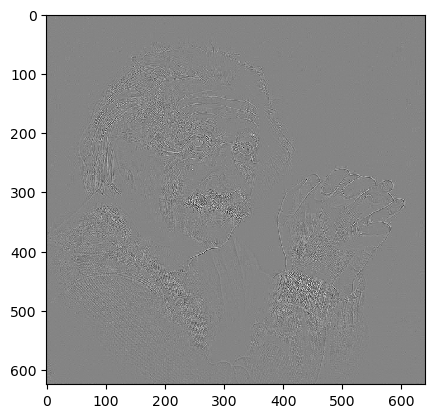

In [4]:
import pathlib
import os
import sys
import subprocess
import logging
import platform

from dataclasses import dataclass

import cv2 as cv
import matplotlib.pyplot as plt

def fatal_error(msg):
  logging.critical(msg)
  breakpoint()
  sys.exit()

def warn(msg):
  logging.warning(msg)
  # NOTE(Ryan): Disable by passing -O to interpreter
  if __debug__:
    breakpoint()
    sys.exit()

def trace(msg):
  if __debug__:
    logging.debug(msg)


# what is format of input image?
# 1. Open and read image files.
# 2. Display and write image files. (binary segmented image)
# 3. Perform basic image processing operations on images.
# 4. Implement and apply various automatic thresholding techniques to images.

# For this assignment (same as for the labs), make sure that in your Jupyter notebook the
# input images are readable from the location specified as an argument, and all output images
# and other requested results are displayed in the notebook environment. All cells in your
# notebook should have been executed so that the tutor/marker does not have to execute the
# notebook again to see the results.
def make_empty_matrix(n):
  return [[0] * n for i in range(n)]


def clamp(val, limit):
  clamped_val = val

  if val < 0:
    clamped_val = 0
  elif val >= limit:
    clamped_val = limit - 1
  
  return clamped_val

def translate(x0, x1, val, x2, x3):
  val_fraction = ((val - x0) / (x1 - x0))
  
  return x2 + (val_fraction * (x3 - x2))

def make_k3x3_laplace():
  k3x3 = make_empty_matrix(3)

  k3x3[0][0] = 0 
  k3x3[1][0] = 1 
  k3x3[2][0] = 0 

  k3x3[0][1] = 1 
  k3x3[1][1] = -4 
  k3x3[2][1] = 1 

  k3x3[0][2] = 0 
  k3x3[1][2] = 1 
  k3x3[2][2] = 0 

  return k3x3

def convolve_k3x3_laplace(k3x3, m3x3):
  result = 0

  for x in range(3):
    for y in range(3):
      result += (k3x3[y][x] * m3x3[y][x])

  return result

def make_m3x3_from_cv_image(cv_img, centre_x, centre_y):
  m3x3 = make_empty_matrix(3)

  w = cv_img.shape[1]
  h = cv_img.shape[0]

  # NOTE(Ryan): Duplicating last pixel for border problem   
  x00 = clamp(centre_x - 1, w)
  x01 = clamp(centre_x, w)
  x02 = clamp(centre_x + 1, w)

  y00 = clamp(centre_y - 1, h)
  y01 = clamp(centre_y, h)
  y02 = clamp(centre_y + 1, h)

  # NOTE(Ryan): First pixel is fine as greyscale
  m3x3[0][0] = cv_img[y00, x00][0] 
  m3x3[0][1] = cv_img[y00, x01][0]
  m3x3[0][2] = cv_img[y00, x02][0]

  m3x3[1][0] = cv_img[y01, x00][0]
  m3x3[1][1] = cv_img[y01, x01][0]
  m3x3[1][2] = cv_img[y01, x02][0]

  m3x3[2][0] = cv_img[y02, x00][0] 
  m3x3[2][1] = cv_img[y02, x01][0]
  m3x3[2][2] = cv_img[y02, x02][0]

  return m3x3


def compute_laplacian(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  k3x3_laplace = make_k3x3_laplace() 

  output_img_gray_values = [0] * (img_width * img_height)
  
  for x in range(img_width):
    for y in range(img_height):
      m3x3 = make_m3x3_from_cv_image(img, x, y)

      gray_value = convolve_k3x3_laplace(k3x3_laplace, m3x3)

      output_img_gray_values[y * img_width + x] = gray_value

  min_convolved = min(output_img_gray_values)
  max_convolved = max(output_img_gray_values)

  for x in range(img_width):
    for y in range(img_height):
      cur_gray = output_img_gray_values[y * img_width + x]
      normalised_gray = translate(min_convolved, max_convolved, cur_gray, 0, 255)
      output_img[y, x] = [normalised_gray] * 3
 
  return output_img

def contrast_stretch(i, a, b, c, d):
  return (i - c) * ((b - a) / (d - c)) + a

# TODO(Ryan): For BGR, generalise for number of channels
def contrast_stretch_grayscale(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  min_input = sys.maxsize
  max_input = 0
  for x in range(img_width):
    for y in range(img_height):
      gray_value = img[y, x][0]
      if gray_value > max_input:
        max_input = gray_value
      if gray_value < min_input:
        min_input = gray_value

  for x in range(img_width):
    for y in range(img_height):
      output_img[y, x] = [contrast_stretch(img[y, x][0], 0, 255, min_input, max_input)] * 3

  return output_img


def main():
  trace(f"opencv: {cv.__version__}")

  images_dir="COMP9517_23T2_Lab1_Images"

  einstein_img = cv.imread(f"{images_dir}/Einstein.png")

  laplacian_img = compute_laplacian(einstein_img)
  plt.imshow(laplacian_img)

  #contrast_stretched_laplacian_img = contrast_stretch_grayscale(laplacian_img)
  #plt.imshow(contrast_stretched_laplacian_img)

  #plt.imshow(cv.cvtColor(image, cv2.COLOR_BGR2RGB)) # cv2 uses BGR but plt uses RGB, hence the conversion
  # cv.imshow('contrast_stretched_laplacian_img', contrast_stretched_laplacian_img)
  # cv.waitKey()


if __name__ == "__main__":
  # NOTE(Ryan): Disable breakpoints if not running under a debugger
  # if sys.gettrace() is None:
  #   os.environ["PYTHONBREAKPOINT"] = "0"

  # directory_of_running_script = pathlib.Path(__file__).parent.resolve()
  # os.chdir(directory_of_running_script)

  logging.basicConfig(level=logging.DEBUG)

  trace(f"python: {platform.python_version()}")

  main()


DEBUG:root:python: 3.8.10
DEBUG:root:opencv: 4.2.0
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIX

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal bold condensed>) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Symbols' (NotoSansSymbols-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Purisa' (Purisa-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Ahom' (NotoSerifAhom-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'URW Bookman' (URWBookman-Demi.otf) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mahajani' (NotoSansMahajani-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-Black.ttf) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-Heavy.ttf)

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Devanagari' (NotoSansDevanagari-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-HairlineItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Hatran' (NotoSansHatran-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Limbu' (NotoSansLimbu-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif CJK JP' (NotoSerifCJK-Bold.ttc) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Roman Slanted' (lmromanslant10-regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mro' (NotoSansMro-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: sc

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Dyuthi' (Dyuthi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Mono Caps' (lmmonocaps10-oblique.otf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gurmukhi' (NotoSansGurmukhi-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif' (NotoSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Telugu' (NotoSerifTelugu-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Bonum Math' (

DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Termes' (texgyretermes-italic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Padauk' (Padauk-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstOne' (KacstOne-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Roman Caps' (lmromancaps10-regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Mo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSerif' (FreeSerifBold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Kannada' (NotoSerifKannada-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliqUrdu-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chandas' (chandas1-2.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Laksaman' (Laksaman-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'RaghuMalayalamSans' (RaghuMalayalamSans-Re

DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSerif' (FreeSerifBoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typist' (TlwgTypist-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gurmukhi UI' (NotoSansGurmukhiUI-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukti Narrow' (MuktiNarrowBold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Heros Cn' (texgyreheroscn-bolditalic.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tai Le' (NotoSansTaiLe-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans' (NotoSans-Italic.ttf)

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Batak' (NotoSansBatak-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Hungarian' (NotoSansOldHungarian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Schola' (texgyreschola-italic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSans' (FreeSansBold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Mono Prop' (lmmonoprop10-oblique.otf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Anatolian Hieroglyphs' (NotoSansAnatolianHieroglyphs-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Psalter Pahlavi' (NotoSansPsalterPahlavi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Mono' (NotoMono-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rasa' (Rasa-Light.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Pagella Math' (texgyrepagella-math.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Adventor' (texgyreadventor-bolditalic.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kaithi' (NotoSansKaithi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old North Arabian' (NotoSansOldNorthArabian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manage

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Saab' (Saab.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Pagella' (texgyrepagella-regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans' (NotoSans-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Termes' (texgyretermes-bolditalic.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cham' (NotoSansCham-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Padauk Book' (PadaukBook-Bold.ttf) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rasa' (Rasa-Regular.ttf) normal norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'eufm10' (eufm10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-MI.ttf) italic normal medium normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif' (NotoSerif-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'TeX Gyre Pagella' (texgyrepagella-bolditalic.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Hebrew' (NotoSerifHebrew-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Telugu' (Lohit-Telugu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstNaskh' (KacstNaskh.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Sans Quotation' (lmsansquot8-boldoblique.otf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Sans Demi Cond' (lmsansdemicond10-regular.otf) normal normal regular condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 

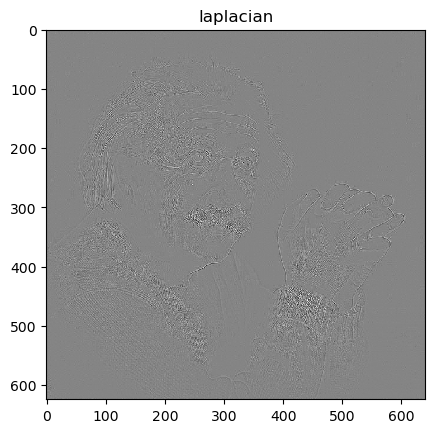

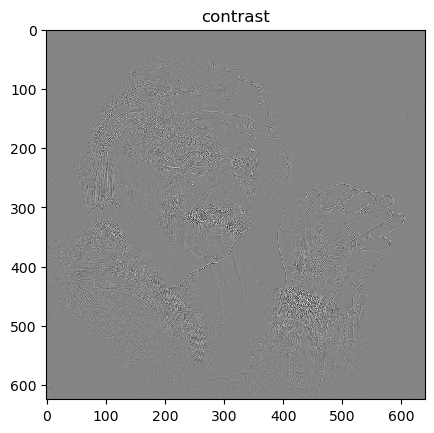

In [5]:
import pathlib
import os
import sys
import subprocess
import logging
import platform

from dataclasses import dataclass

import cv2 as cv
import matplotlib.pyplot as plt

def fatal_error(msg):
  logging.critical(msg)
  breakpoint()
  sys.exit()

def warn(msg):
  logging.warning(msg)
  # NOTE(Ryan): Disable by passing -O to interpreter
  if __debug__:
    breakpoint()
    sys.exit()

def trace(msg):
  if __debug__:
    logging.debug(msg)


# what is format of input image?
# 1. Open and read image files.
# 2. Display and write image files. (binary segmented image)
# 3. Perform basic image processing operations on images.
# 4. Implement and apply various automatic thresholding techniques to images.

# For this assignment (same as for the labs), make sure that in your Jupyter notebook the
# input images are readable from the location specified as an argument, and all output images
# and other requested results are displayed in the notebook environment. All cells in your
# notebook should have been executed so that the tutor/marker does not have to execute the
# notebook again to see the results.
def make_empty_matrix(n):
  return [[0] * n for i in range(n)]


def clamp(val, limit):
  clamped_val = val

  if val < 0:
    clamped_val = 0
  elif val >= limit:
    clamped_val = limit - 1
  
  return clamped_val

def translate(x0, x1, val, x2, x3):
  val_fraction = ((val - x0) / (x1 - x0))
  
  return x2 + (val_fraction * (x3 - x2))

def make_k3x3_laplace():
  k3x3 = make_empty_matrix(3)

  k3x3[0][0] = 0 
  k3x3[1][0] = 1 
  k3x3[2][0] = 0 

  k3x3[0][1] = 1 
  k3x3[1][1] = -4 
  k3x3[2][1] = 1 

  k3x3[0][2] = 0 
  k3x3[1][2] = 1 
  k3x3[2][2] = 0 

  return k3x3

def convolve_k3x3_laplace(k3x3, m3x3):
  result = 0

  for x in range(3):
    for y in range(3):
      result += (k3x3[y][x] * m3x3[y][x])

  return result

def make_m3x3_from_cv_image(cv_img, centre_x, centre_y):
  m3x3 = make_empty_matrix(3)

  w = cv_img.shape[1]
  h = cv_img.shape[0]

  # NOTE(Ryan): Duplicating last pixel for border problem   
  x00 = clamp(centre_x - 1, w)
  x01 = clamp(centre_x, w)
  x02 = clamp(centre_x + 1, w)

  y00 = clamp(centre_y - 1, h)
  y01 = clamp(centre_y, h)
  y02 = clamp(centre_y + 1, h)

  # NOTE(Ryan): First pixel is fine as greyscale
  m3x3[0][0] = cv_img[y00, x00][0] 
  m3x3[0][1] = cv_img[y00, x01][0]
  m3x3[0][2] = cv_img[y00, x02][0]

  m3x3[1][0] = cv_img[y01, x00][0]
  m3x3[1][1] = cv_img[y01, x01][0]
  m3x3[1][2] = cv_img[y01, x02][0]

  m3x3[2][0] = cv_img[y02, x00][0] 
  m3x3[2][1] = cv_img[y02, x01][0]
  m3x3[2][2] = cv_img[y02, x02][0]

  return m3x3


def compute_laplacian(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  k3x3_laplace = make_k3x3_laplace() 

  output_img_gray_values = [0] * (img_width * img_height)
  
  for x in range(img_width):
    for y in range(img_height):
      m3x3 = make_m3x3_from_cv_image(img, x, y)

      gray_value = convolve_k3x3_laplace(k3x3_laplace, m3x3)

      output_img_gray_values[y * img_width + x] = gray_value

  min_convolved = min(output_img_gray_values)
  max_convolved = max(output_img_gray_values)

  for x in range(img_width):
    for y in range(img_height):
      cur_gray = output_img_gray_values[y * img_width + x]
      normalised_gray = translate(min_convolved, max_convolved, cur_gray, 0, 255)
      output_img[y, x] = [normalised_gray] * 3
 
  return output_img

def contrast_stretch(i, a, b, c, d):
  return (i - c) * ((b - a) / (d - c)) + a

# TODO(Ryan): For BGR, generalise for number of channels
def contrast_stretch_grayscale(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  min_input = sys.maxsize
  max_input = 0
  for x in range(img_width):
    for y in range(img_height):
      gray_value = img[y, x][0]
      if gray_value > max_input:
        max_input = gray_value
      if gray_value < min_input:
        min_input = gray_value

  for x in range(img_width):
    for y in range(img_height):
      output_img[y, x] = [contrast_stretch(img[y, x][0], 0, 255, min_input, max_input)] * 3

  return output_img


def main():
  trace(f"opencv: {cv.__version__}")

  images_dir="COMP9517_23T2_Lab1_Images"

  einstein_img = cv.imread(f"{images_dir}/Einstein.png")

  laplacian_img = compute_laplacian(einstein_img)
  plt.imshow(laplacian_img)
  plt.title('laplacian')
  plt.show()

  contrast_stretched_laplacian_img = contrast_stretch_grayscale(laplacian_img)
  plt.imshow(contrast_stretched_laplacian_img)
  plt.title('contrast')
  plt.show()

  #plt.imshow(cv.cvtColor(image, cv2.COLOR_BGR2RGB)) # cv2 uses BGR but plt uses RGB, hence the conversion
  # cv.imshow('contrast_stretched_laplacian_img', contrast_stretched_laplacian_img)
  # cv.waitKey()


if __name__ == "__main__":
  # NOTE(Ryan): Disable breakpoints if not running under a debugger
  # if sys.gettrace() is None:
  #   os.environ["PYTHONBREAKPOINT"] = "0"

  # directory_of_running_script = pathlib.Path(__file__).parent.resolve()
  # os.chdir(directory_of_running_script)

  logging.basicConfig(level=logging.DEBUG)

  trace(f"python: {platform.python_version()}")

  main()

DEBUG:root:python: 3.8.10
DEBUG:root:opencv: 4.2.0


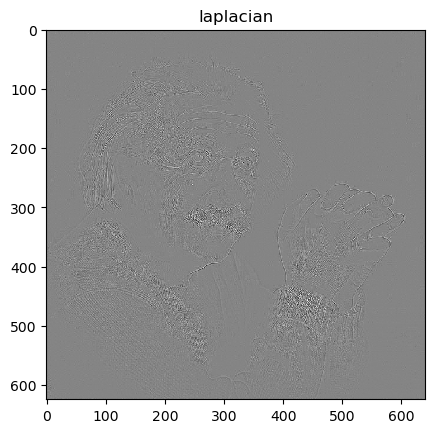

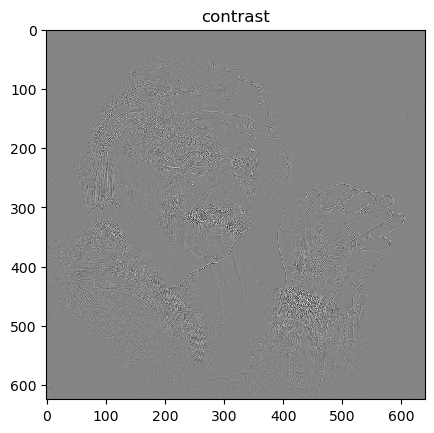

In [6]:
import pathlib
import os
import sys
import subprocess
import logging
import platform

from dataclasses import dataclass

import cv2 as cv
import matplotlib.pyplot as plt

def fatal_error(msg):
  logging.critical(msg)
  breakpoint()
  sys.exit()

def warn(msg):
  logging.warning(msg)
  # NOTE(Ryan): Disable by passing -O to interpreter
  if __debug__:
    breakpoint()
    sys.exit()

def trace(msg):
  if __debug__:
    logging.debug(msg)


# what is format of input image?
# 1. Open and read image files.
# 2. Display and write image files. (binary segmented image)
# 3. Perform basic image processing operations on images.
# 4. Implement and apply various automatic thresholding techniques to images.

# For this assignment (same as for the labs), make sure that in your Jupyter notebook the
# input images are readable from the location specified as an argument, and all output images
# and other requested results are displayed in the notebook environment. All cells in your
# notebook should have been executed so that the tutor/marker does not have to execute the
# notebook again to see the results.
def make_empty_matrix(n):
  return [[0] * n for i in range(n)]


def clamp(val, limit):
  clamped_val = val

  if val < 0:
    clamped_val = 0
  elif val >= limit:
    clamped_val = limit - 1
  
  return clamped_val

def translate(x0, x1, val, x2, x3):
  val_fraction = ((val - x0) / (x1 - x0))
  
  return x2 + (val_fraction * (x3 - x2))

def make_k3x3_laplace():
  k3x3 = make_empty_matrix(3)

  k3x3[0][0] = 0 
  k3x3[1][0] = 1 
  k3x3[2][0] = 0 

  k3x3[0][1] = 1 
  k3x3[1][1] = -4 
  k3x3[2][1] = 1 

  k3x3[0][2] = 0 
  k3x3[1][2] = 1 
  k3x3[2][2] = 0 

  return k3x3

def convolve_k3x3_laplace(k3x3, m3x3):
  result = 0

  for x in range(3):
    for y in range(3):
      result += (k3x3[y][x] * m3x3[y][x])

  return result

def make_m3x3_from_cv_image(cv_img, centre_x, centre_y):
  m3x3 = make_empty_matrix(3)

  w = cv_img.shape[1]
  h = cv_img.shape[0]

  # NOTE(Ryan): Duplicating last pixel for border problem   
  x00 = clamp(centre_x - 1, w)
  x01 = clamp(centre_x, w)
  x02 = clamp(centre_x + 1, w)

  y00 = clamp(centre_y - 1, h)
  y01 = clamp(centre_y, h)
  y02 = clamp(centre_y + 1, h)

  # NOTE(Ryan): First pixel is fine as greyscale
  m3x3[0][0] = cv_img[y00, x00][0] 
  m3x3[0][1] = cv_img[y00, x01][0]
  m3x3[0][2] = cv_img[y00, x02][0]

  m3x3[1][0] = cv_img[y01, x00][0]
  m3x3[1][1] = cv_img[y01, x01][0]
  m3x3[1][2] = cv_img[y01, x02][0]

  m3x3[2][0] = cv_img[y02, x00][0] 
  m3x3[2][1] = cv_img[y02, x01][0]
  m3x3[2][2] = cv_img[y02, x02][0]

  return m3x3


def compute_laplacian(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  k3x3_laplace = make_k3x3_laplace() 

  output_img_gray_values = [0] * (img_width * img_height)
  
  for x in range(img_width):
    for y in range(img_height):
      m3x3 = make_m3x3_from_cv_image(img, x, y)

      gray_value = convolve_k3x3_laplace(k3x3_laplace, m3x3)

      output_img_gray_values[y * img_width + x] = gray_value

  min_convolved = min(output_img_gray_values)
  max_convolved = max(output_img_gray_values)

  for x in range(img_width):
    for y in range(img_height):
      cur_gray = output_img_gray_values[y * img_width + x]
      normalised_gray = translate(min_convolved, max_convolved, cur_gray, 0, 255)
      output_img[y, x] = [normalised_gray] * 3
 
  return output_img

def contrast_stretch(i, a, b, c, d):
  return (i - c) * ((b - a) / (d - c)) + a

# TODO(Ryan): For BGR, generalise for number of channels
def contrast_stretch_grayscale(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  min_input = sys.maxsize
  max_input = 0
  for x in range(img_width):
    for y in range(img_height):
      gray_value = img[y, x][0]
      if gray_value > max_input:
        max_input = gray_value
      if gray_value < min_input:
        min_input = gray_value

  for x in range(img_width):
    for y in range(img_height):
      output_img[y, x] = [contrast_stretch(img[y, x][0], 0, 255, min_input, max_input)] * 3

  return output_img


def main():
  trace(f"opencv: {cv.__version__}")

  images_dir="COMP9517_23T2_Lab1_Images"

  einstein_img = cv.imread(f"{images_dir}/Einstein.png")

  laplacian_img = compute_laplacian(einstein_img)
  plt.imshow(laplacian_img)
  plt.title('laplacian')
  plt.show()

  contrast_stretched_laplacian_img = contrast_stretch_grayscale(laplacian_img)
  plt.imshow(cv.cvtColor(contrast_stretched_laplacian_img, cv.COLOR_BGR2RGB))
  plt.title('contrast')
  plt.show()

  #plt.imshow(cv.cvtColor(image, cv2.COLOR_BGR2RGB)) # cv2 uses BGR but plt uses RGB, hence the conversion
  # cv.imshow('contrast_stretched_laplacian_img', contrast_stretched_laplacian_img)
  # cv.waitKey()


if __name__ == "__main__":
  # NOTE(Ryan): Disable breakpoints if not running under a debugger
  # if sys.gettrace() is None:
  #   os.environ["PYTHONBREAKPOINT"] = "0"

  # directory_of_running_script = pathlib.Path(__file__).parent.resolve()
  # os.chdir(directory_of_running_script)

  logging.basicConfig(level=logging.DEBUG)

  trace(f"python: {platform.python_version()}")

  main()
